# New issue with black particles

In some new images (with better image quality), `find_black` function does not work as good. Below is an example.

In [43]:
from skimage import io
import matplotlib.pyplot as plt
from bwtrack.bwtrack import find_black, find_white, show_result
import numpy as np
from myimagelib.myImageLib import to8bit, matlab_style_gauss2D, bestcolor
from scipy.signal import convolve2d
from myimagelib.xcorr_funcs import normxcorr2, FastPeakFind
import pandas as pd
from skimage.feature import peak_local_max
from skimage import io, measure, draw
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import cv2
import os

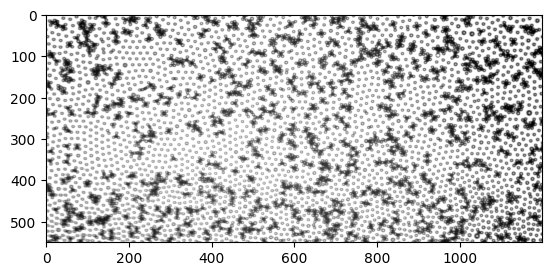

In [36]:
%matplotlib inline
img = io.imread(r"..\..\test_images\2023-01-29_black.tif")
plt.imshow(img, cmap="gray")

## 1 Old method (bwtrack v1.3)

Note that the functions here are from old versions of bwtrack. You may not get the same results if you have already updated bwtrack.

### 1.1 Use default parameters

`find_black` only requires 1 argument -- the input image, and it accepts optional argument, e.g. size, thres and std_thres to filter out false positives. See the documentation of the function below.

In [37]:
help(find_black)

Help on function find_black in module bwtrack.bwtrack:

find_black(img, size=7, thres=None, std_thres=None, plot_hist=False)
    Find black particles in 乔哥's image. 
    
    :param img: raw image to find particles in 
    :type img: 2d array
    :param size: diameter of particle (px)
    :type size: int
    :param thres: threshold of mean intensity for discerning black and white particles. If None, the function will plot a histogram of mean intensity to help us.
    :type thres: int
    :param std_thres: threshold of standard deviation for discerning black and white particles. If None, the function will plot a histogram of standard deviation to help us.
    
    .. note::
    
       If ``thres=None`` or ``std_thres=None``, all detected features will be returned. Histograms of mean intensity and standard deviation will be plotted to help us set the threshold.
    
    :return: list of particle positions, pixel value sums and corr map peak values (x, y, pv, peak)
    :rtype: pandas.Dat

We first use the default parameter set, i.e. size=7, thres=None, std_thres=None.

In [38]:
black = find_black(img)

Threshold value(s) are missing, all detected features are returned.


(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

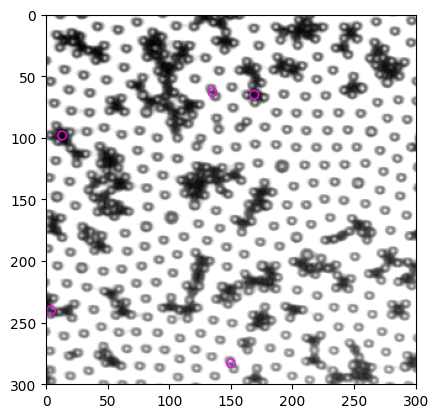

In [39]:
show_result(img, black, size=7, ROI=[0, 300, 300, 0])

Only very few black particles are detected. 

### 1.2 Try to vary optional arguments

`size=6`.

C:\Users\liuzy\Documents\Github\mylib\src\myimagelib\xcorr_funcs.py:42: RuntimeWarning: divide by zero encountered in divide
  out = out / np.sqrt(image * template)
C:\Users\liuzy\Documents\Github\mylib\src\myimagelib\xcorr_funcs.py:42: RuntimeWarning: invalid value encountered in divide
  out = out / np.sqrt(image * template)


Threshold value(s) are missing, all detected features are returned.


(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

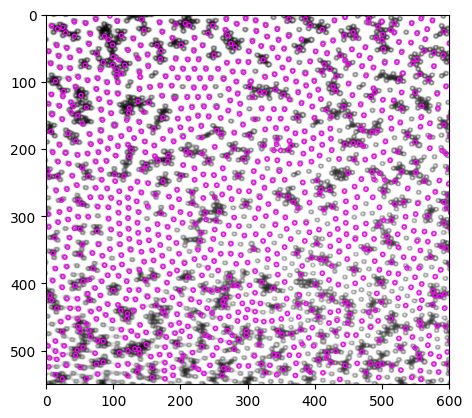

In [40]:
black = find_black(img, size=6)
show_result(img, black, size=6, ROI=[0, 600, 600, 0])

Many more black particles are detected, but meanwhile many white particles are recognized as black. We can look at the histograms and set threshold to distinguish true black particles from false positives.

C:\Users\liuzy\Documents\Github\mylib\src\myimagelib\xcorr_funcs.py:42: RuntimeWarning: divide by zero encountered in divide
  out = out / np.sqrt(image * template)
C:\Users\liuzy\Documents\Github\mylib\src\myimagelib\xcorr_funcs.py:42: RuntimeWarning: invalid value encountered in divide
  out = out / np.sqrt(image * template)


Threshold value(s) are missing, all detected features are returned.


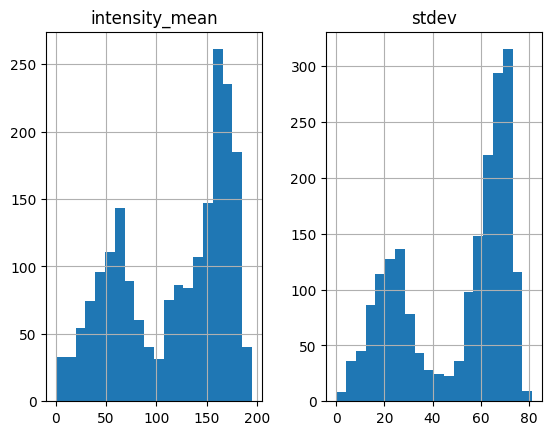

In [41]:
black = find_black(img, size=6, plot_hist=True)

Try to set intensity threshold at 100.

C:\Users\liuzy\Documents\Github\mylib\src\myimagelib\xcorr_funcs.py:42: RuntimeWarning: divide by zero encountered in divide
  out = out / np.sqrt(image * template)
C:\Users\liuzy\Documents\Github\mylib\src\myimagelib\xcorr_funcs.py:42: RuntimeWarning: invalid value encountered in divide
  out = out / np.sqrt(image * template)


Standard deviation threshold is not set, only apply mean intensity threshold


(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

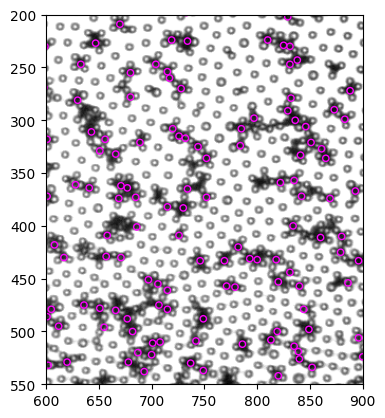

In [51]:
black = find_black(img, size=6, thres=100)
show_result(img, black, size=6, ROI=[600, 900, 600, 200])

The result is good.

## 2 Try `find_white`

Although there are less problems with `find_white`, according to Qiaoge, I test the goodness of white tracking on these new images. 

C:\Users\liuzy\Documents\Github\mylib\src\myimagelib\xcorr_funcs.py:42: RuntimeWarning: divide by zero encountered in divide
  out = out / np.sqrt(image * template)
C:\Users\liuzy\Documents\Github\mylib\src\myimagelib\xcorr_funcs.py:42: RuntimeWarning: invalid value encountered in divide
  out = out / np.sqrt(image * template)


Threshold value(s) are missing, all detected features are returned.


(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

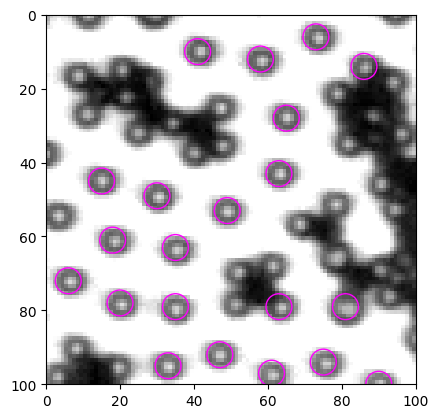

In [31]:
white = find_white(img, size=7)
show_result(img, white, size=7)

Again, isolated particles can be found with good accuracy, but white particles in clusters are harder to find. There are two issues:

- look smaller than isolated particles
- intensity profile is not symmetric, which is different from the template

## 3 Examine the pattern of black particles

The current method to find black particles are based on empirical Gaussian template, which may not be the best template to use. In the white-particle notebook, we look closely at the patterns of several white particles, and find a good template -- double-well. For black particle, a close look at the patterns might also be helpful. Let's do it in this section.

### 3.0 Why some black particles are not found?

C:\Users\liuzy\Documents\Github\mylib\src\myimagelib\xcorr_funcs.py:42: RuntimeWarning: divide by zero encountered in divide
  out = out / np.sqrt(image * template)


Threshold value(s) are missing, all detected features are returned.


(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

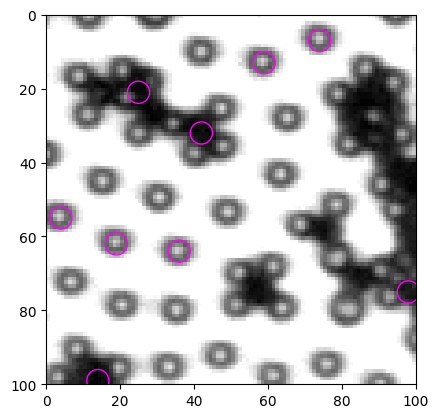

In [19]:
black = find_black(img, size=8, thres=None)
show_result(img, black, size=6)

The particles (likely 2) at around (85, 20) are not detected by `find_black`. Let's look at the intermediate results step by step. 

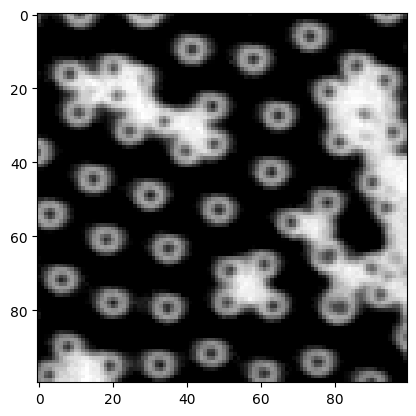

In [5]:
# 1. inverted image
I = img[:100, :100]
I = to8bit(I)
inv_img = 255 - I
plt.imshow(inv_img, cmap="gray")

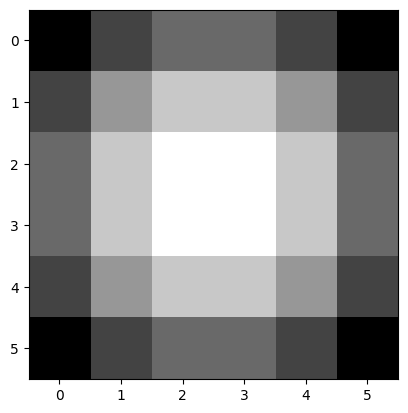

In [27]:
# Gaussian template
size = 6
gauss_shape = (size, size)
gauss_sigma = size / 2.   
gauss_mask = matlab_style_gauss2D(shape=gauss_shape,sigma=gauss_sigma)
plt.imshow(gauss_mask, cmap="gray")

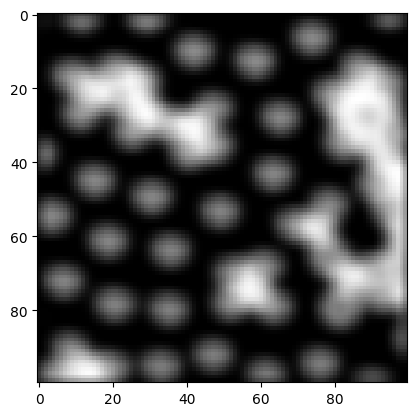

In [28]:
# convolve raw image with gaussian mask, make it blurry
timg = convolve2d(inv_img, gauss_mask, mode="same") 
plt.imshow(timg, cmap="gray")

C:\Users\liuzy\Documents\Github\mylib\src\myimagelib\xcorr_funcs.py:42: RuntimeWarning: divide by zero encountered in divide
  out = out / np.sqrt(image * template)


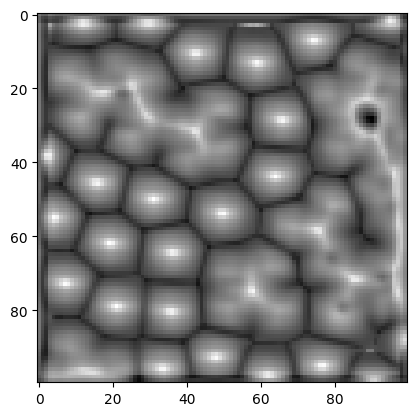

In [29]:
# correlation map
corr = normxcorr2(gauss_mask, timg, "same") # 找匹配mask的位置
plt.imshow(corr, cmap="gray")

In [30]:
peak = FastPeakFind(corr) # 无差别找峰

In [31]:
peak.shape

(2, 31)

In [32]:
# Try peak_local_max
help(peak_local_max)

Help on function peak_local_max in module skimage.feature.peak:

peak_local_max(image, min_distance=1, threshold_abs=None, threshold_rel=None, exclude_border=True, indices=True, num_peaks=inf, footprint=None, labels=None, num_peaks_per_label=inf, p_norm=inf)
    Find peaks in an image as coordinate list or boolean mask.
    
    Peaks are the local maxima in a region of `2 * min_distance + 1`
    (i.e. peaks are separated by at least `min_distance`).
    
    If both `threshold_abs` and `threshold_rel` are provided, the maximum
    of the two is chosen as the minimum intensity threshold of peaks.
    
    .. versionchanged:: 0.18
        Prior to version 0.18, peaks of the same height within a radius of
        `min_distance` were all returned, but this could cause unexpected
        behaviour. From 0.18 onwards, an arbitrary peak within the region is
        returned. See issue gh-2592.
    
    Parameters
    ----------
    image : ndarray
        Input image.
    min_distance : int,

In [33]:
pcm = peak_local_max(corr, min_distance=1)
pcm.shape

(74, 2)

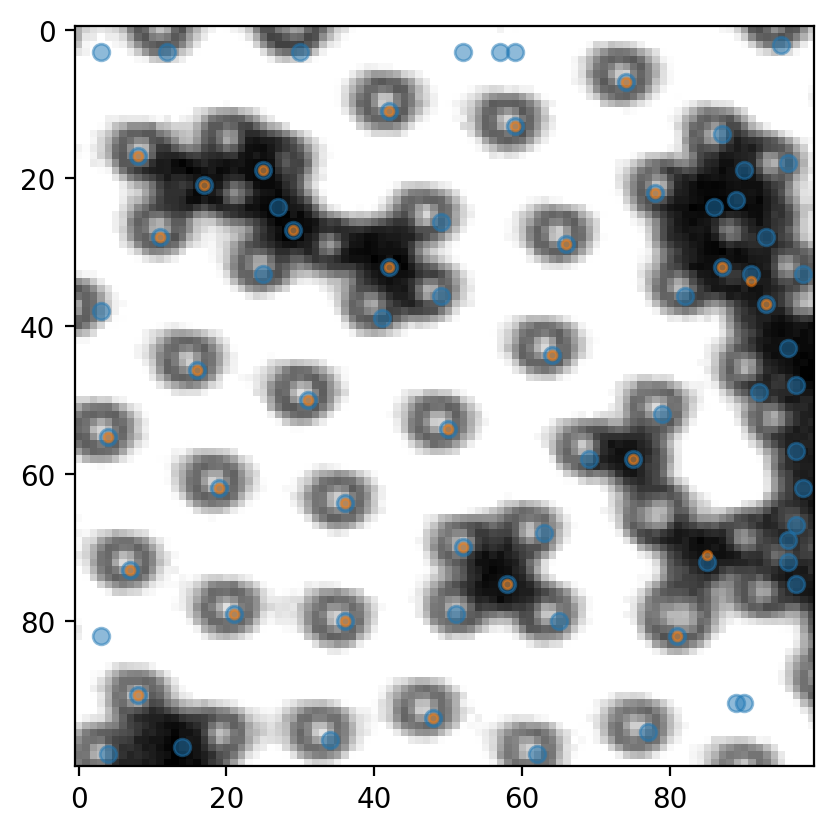

In [34]:
plt.figure(dpi=200)
plt.imshow(I, cmap="gray")
plt.scatter(pcm[:, 1], pcm[:, 0], alpha=0.5)
plt.scatter(peak[1, :], peak[0, :], s=10, alpha=0.5)

`peak_local_max` finds more peaks than `FastPeakFind` and is potentially faster, consider using it in `find_black`.

### 3.1 A close look at black particle patterns

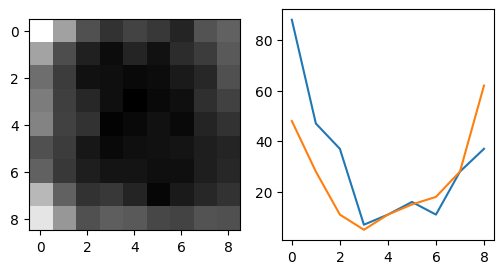

In [19]:
# this one is found by the old template
center = (56, 74)
size = 9
crop = I[center[1]-size//2:center[1]-size//2+size, center[0]-size//2:center[0]-size//2+size]

fig, ax = plt.subplots(ncols=2, figsize=(6, 3))
ax[0].imshow(crop, cmap="gray")
ax[1].plot(crop[size//2, :])
ax[1].plot(crop[:, size//2])

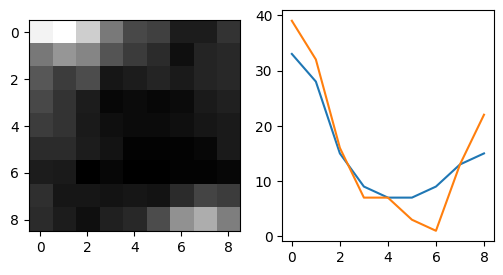

In [26]:
# this one is NOT found by the old template
center = (85, 22)
size = 9
crop = I[center[1]-size//2:center[1]-size//2+size, center[0]-size//2:center[0]-size//2+size]

fig, ax = plt.subplots(ncols=2, figsize=(6, 3))
ax[0].imshow(crop, cmap="gray")
ax[1].plot(crop[size//2, :])
ax[1].plot(crop[:, size//2])

The peak shape is quite pronounced, in contrary to my intuition. So supposedly, Gaussian template is still a good choice. 